interactive(children=(IntSlider(value=0, description='frame', max=49), Output()), _dom_classes=('widget-intera…

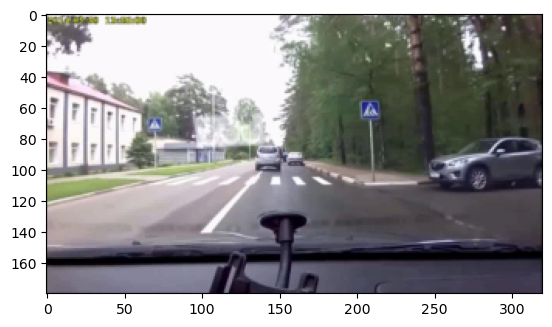

In [1]:
import albumentations as A
from ipywidgets import interact
from matplotlib import pyplot as plt
import numpy as np 
import cv2
from albumentations.pytorch.transforms import ToTensorV2


def get_frames(path):
    cap = cv2.VideoCapture(path)
    frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    imgs = []        
    for fidx in range(frames):
        _, img = cap.read()            
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgs.append(img)
    
    ret = {f"image{i}":imgs[i] for i in range(1, len(imgs))}
    ret['image'] = imgs[0]
    return ret

def aug(transforms, images):
    res = transforms(**images)
    images = np.zeros((len(images), 180, 320, 3), dtype=np.uint8)
    images[0, :, :, :] = res["image"]
    for i in range(1, len(images)):
        images[i, :, :, :] = res[f"image{i}"]
    return images, res

transforms = A.Compose([
    A.Resize(height=180, width=320),
    A.RandomBrightnessContrast(p=0.2),

],additional_targets={f"image{i}":"image" for i in range(1, 50)})

frames = get_frames("./data/train/TRAIN_0001.mp4")
frames,res = aug(transforms, frames)

@interact(frame=(0, len(frames)-1))
def show_frame(frame=(0)):
    plt.imshow(frames[frame,:,:,:])
    
show_frame()

(50, 180, 320, 3)


interactive(children=(IntSlider(value=0, description='frame', max=49), Output()), _dom_classes=('widget-intera…

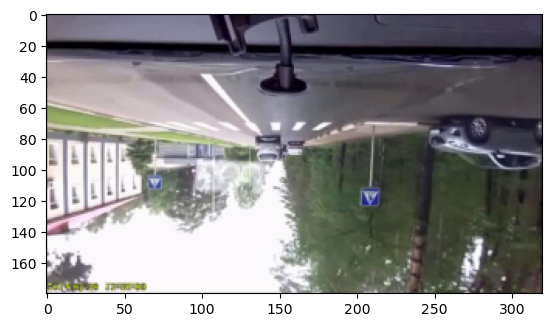

In [2]:
from utils import CustomDataset
transforms = A.Compose([
    A.Resize(height=180, width=320),
    A.VerticalFlip(p=1),

],additional_targets={f"image{i}":"image" for i in range(1, 50)})

dataset = CustomDataset(["./train/TRAIN_0001.mp4"],transform=transforms)
frames = dataset.__getitem__(0)
frames = np.array(frames,dtype=np.uint8).transpose(1,2,3,0)
print(frames.shape)

@interact(frame=(0, len(frames)-1))
def show_frame(frame=(0)):
    plt.imshow(frames[frame,:,:,:])
    
show_frame()

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np


class MyDataset(Dataset):
    def __init__(self):
        x = np.random.rand(1000, 3)  # 1000 3-dim samples
        self.x = [x[i].tolist() for i in range(1000)]
        y = np.random.randint(low=0, high=2, size=(1000,))
        self.y = [y[i] for i in range(1000)]

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


def collate_fn(batch):
    data_list, label_list = [], []
    for _data, _label in batch:
        data_list.append(_data)
        label_list.append(_label)
    return torch.Tensor(data_list), torch.LongTensor(label_list)


if __name__ == "__main__":
    dataset = MyDataset()
    print(len(dataset))
    print(dataset[-1])

    print("-----not collate_fn-----")
    dataloader = DataLoader(dataset, batch_size=3, shuffle=False)
    for data, label in dataloader:
        print(data)
        print(label)
        break
    print("-----collate_fn-----")
    dataloader = DataLoader(dataset, batch_size=3, shuffle=False, collate_fn=collate_fn)
    for data, label in dataloader:
        print(data)
        print(label)
        break

1000
([0.30457293421240017, 0.9769595738001755, 0.014798012816343187], 1)
-----not collate_fn-----
[tensor([0.8591, 0.7938, 0.1621], dtype=torch.float64), tensor([0.2114, 0.9877, 0.4597], dtype=torch.float64), tensor([0.5611, 0.6333, 0.5518], dtype=torch.float64)]
tensor([1, 0, 0])
-----collate_fn-----
tensor([[0.8591, 0.2114, 0.5611],
        [0.7938, 0.9877, 0.6333],
        [0.1621, 0.4597, 0.5518]])
tensor([1, 0, 0])


torch.float32


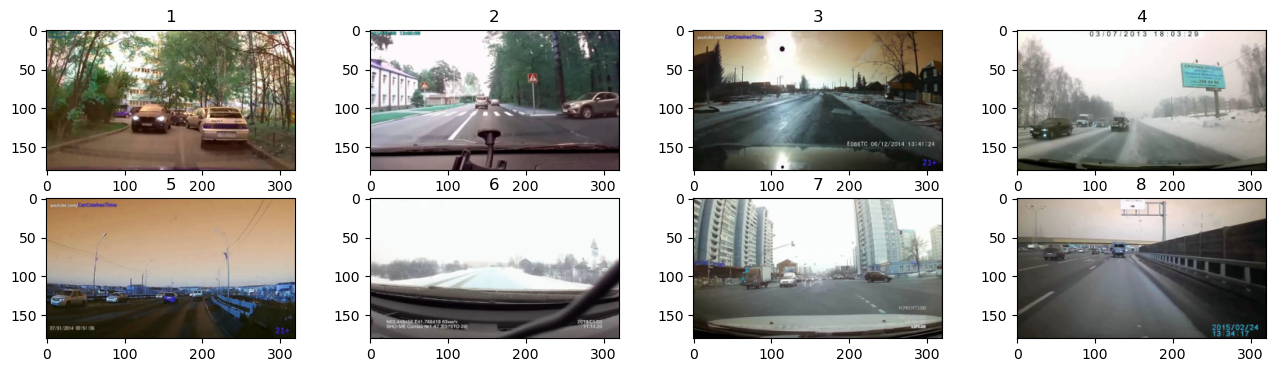

<BarContainer object of 11 artists>

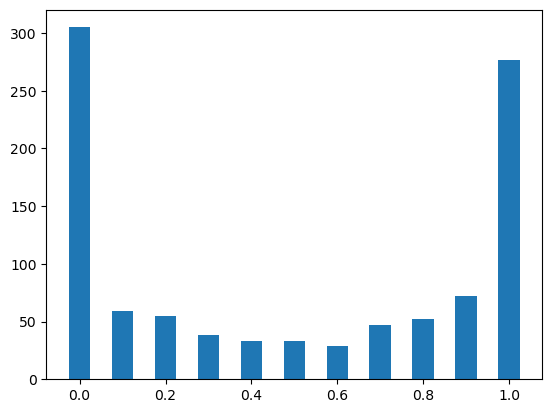

In [9]:
from utils import CustomDataset
import pandas as pd
from torch.utils.data import DataLoader
import argparse

def collate_fn(batch):
    indice = torch.randperm(len(batch))
    value = round(np.random.beta(0.2,0.2),1)
    
    if len(batch[0])==2:
        img = []
        label = []
        for a,b in batch:
            img.append(a)
            label.append(torch.as_tensor(b,dtype=torch.float32))
        img = torch.stack(img)
        label = torch.stack(label)
        shuffle_label = label[indice]
        
        label = value * label + (1 - value) * shuffle_label
    else:
        img = torch.stack(batch)    
    shuffle_img = img[indice]
    
    img = value * img + (1 - value) * shuffle_img
    
    if len(batch[0])==2:
        return img, label
    else:
        return img

args = argparse.ArgumentParser(description="QAT training test")
args.crash = False
df = pd.read_csv("./data/train.csv")
df = df[df['label']>0]
df.reset_index(drop=True,inplace=True)

transforms = A.Compose([
            A.Resize(height=180, width=320),
        ],additional_targets={f"image{i}":"image" for i in range(1, 50)})

train_paths = df['video_path']
train_labels = df['label']

train_dataset = CustomDataset(train_paths,label_list=train_labels, args=args, transform=transforms)
train_loader = DataLoader(train_dataset, batch_size = 8,collate_fn=collate_fn)

fig = plt.figure(figsize=(16,4))
xlabels = [i+1 for i in range(8)]
for k,(img,label) in enumerate(iter(train_loader)):
    for i in range(len(img)):
        plt.subplot(2,4,i+1)
        plt.title(xlabels[i])
        frames = np.array(img[i],dtype=np.uint8).transpose(1,2,3,0)
        plt.imshow(cv2.cvtColor(frames[0], cv2.COLOR_BGR2RGB))
    break
plt.show()
    
check = []
for _ in range(1000):
    check.append(round(np.random.beta(0.2,0.2),1))
    
from collections import Counter
import matplotlib.pyplot as plt
check = Counter(check)
plt.bar(check.keys(), check.values(),width=0.05)
        